In [1]:
import json
import shutil
from datetime import datetime, timedelta

import numpy as np
import strax
from bson import json_util
from tqdm import tqdm
import lz4.frame as lz4

import helix as hx
from helix import units
import strax as sx                    
import numba
import pandas as pd
import scipy as sp
import sys
import os
import shutil
from glob import glob
from matplotlib import pyplot as plt

run_id = 'run10' 
duration = 10  # seconds
raw_data_dir = 'toy_data'  # to save the raw toy data
helix_data_dir = 'test_helix_data'  # to save the run metadata
baseline_step = 0  # add a baseline equal to baseline_step*channel_index to each channel
# methods and classes marked with the @export decorator are added to the __all__ namespace to make them importable via
# the star-notation ('from .module_name import *')
export, __all__ = strax.exporter()


@export
def get_pink_psd(trace_length, sampling_dt, noise_std):
    """
    Returns folded PSD corresponding to 1/f pink noise, empirically scaled to make the standard deviation of the noise
    produced from this PSD to be close to the provided noise_std value

    :param trace_length: length of noise traces in samples
    :param sampling_dt: sampling time in ns
    :param noise_std: noise standard deviation
    :return: a tuple of (f, psd), where f is the array of frequencies in Hz, and psd is the array of PSD components
    in A^2/Hz. Can be plotted with plt.loglog(f, psd)
    """
    f = sp.fft.rfftfreq(trace_length, d=sampling_dt / units.s)
    f[0] = f[1]
    # empirical approximate scaling to match the standard deviation of the resulting noise.
    # This is totally crazy, it's a random expression that scales the PSD in a way that the standard deviation of the
    # noise produced from this PSD somewhat matches the requested noise_std
    # TODO: derive the actual scaling that would properly work and make sense instead of this monster
    scaling = 1 / (1 + (np.log10(trace_length) - 4.5) / 10) ** 2 / 10.3
    psd = scaling*(noise_std**2) / f
    psd[-1] = psd[-1] / 2
    # Could use 0 for the DC component of the PSD, but it messes up the plotting in log scale.
    # The value doesn't matter anyway, we are not generating noise DC components. Using the smallest positive float
    psd[0] = np.nextafter(1, 2)
    f[0] = 0
    return f, psd

def generate_silent_traces(n_traces, psd, sampling_frequency=1.0):
    """
    Function to generate silent traces (zeros) with the same structure as the noise generator.
    :param n_traces: int. Number of traces to generate.
    :param psd: ndarray. Folded power spectral density (not used, but kept for structure consistency).
    :param sampling_frequency: float. Sample frequency in Hz.
    :returns: ndarray. An array of silent (zero) traces.
    """
    trace_length = hx.psd_to_trace_length(len(psd))
    
    # Generate an array of zeros with the appropriate shape
    silent_traces = np.zeros((n_traces, trace_length))
    
    return silent_traces
@export
def load_traces_from_csv(file_path):
    """
    Reads the CSV file containing traces and returns them as a NumPy array.
    :param file_path: str. Path to the CSV file.
    :returns: ndarray. Array of traces with shape (n_traces, 32768).
    """
    traces_df = pd.read_csv(file_path, header=None)
    traces_array = traces_df.to_numpy(dtype=np.float32)
    return traces_array
    
def generate_toy_data(run, duration, directory='toy_data', record_length=hx.DEFAULT_RECORD_LENGTH,
                      sampling_dt=hx.DEFAULT_SAMPLING_DT, template_length=hx.DEFAULT_TEMPLATE_LENGTH,
                      channel_map=hx.DEFAULT_CHANNEL_MAP, noise_std=3, event_rate=1, overwrite=False, helix_data_dir='test_helix_data', baseline_step=0, traces_file='traces.csv'):
    """
    Generates and saves toy data with multiple channels of vacuum and submerged types, physics events consisting of UV
    and QP signals, as well as background lone hits and muon saturated events. CAUTION: it's slow!
    Noise is uncorrelated pink noise, with a correlated 5 kHz feature in all channels. Channels have different baselines

    :param run: run id
    :param duration: run duration in seconds. Caution: the function is slow, don't ask to generate days of data
    :param directory: output directory, where a directory with run_id name will be created
    :param record_length: length of records in each file in time samples
    :param sampling_dt: sampling time in ns
    :param template_length: length of UV and QP templates
    :param channel_map: dictionary of channel types and channel number ranges
    :param noise_std: standard deviation of the noise
    :param event_rate: rate of physics events in Hz
    :param overwrite: a boolean specifying whether the function should overwrite data, if it already exists. If False,
    a RuntimeError is raise when a directory with the same run id exists
    :param helix_data_dir: a directory to save the run metadata. Should be the same as the helix output directory.
    :param baseline_step: add a baseline to each channel, equal to baseline_step * channel_index
    """

    traces_array = load_traces_from_csv(traces_file)
    run_dir = os.path.join(directory, run)
    if os.path.exists(run_dir):
        if overwrite:
            shutil.rmtree(run_dir)
        else:
            raise RuntimeError(f'Directory {run_dir} already exists.')

    os.makedirs(run_dir)

    record_length_s = record_length * sampling_dt / units.s
    n_records = int(duration / record_length_s)
    channels = hx.Channels(channel_map)
    n_channels = len(channels)
    batch_size = 1  # number of records per batch
    sampling_frequency = 1 / (sampling_dt / units.s)

    _, psd = get_pink_psd(record_length * batch_size, sampling_dt, noise_std)


    # adding different baselines to each channel
    baseline = baseline_step * np.arange(n_channels)    
    n_batches = 1
    batch_length_s = 10
    baseline_height = 129.75757  # Adjust as needed

    n_events = np.full(n_batches, int(round(event_rate * batch_length_s)), dtype=int)
    print(f"    n_events:            {n_events}")


    for i in tqdm(range(n_batches)):
        #waveform should be generated under each event and has the dimension of (50, 1250000)
        waveform = generate_silent_traces(n_channels, psd, sampling_frequency)
        event_times = np.linspace(0, batch_size * record_length - template_length, num=n_events[i], dtype=int)
        for ich, ch_type in enumerate(channels.types):
            if ich == 0:
                coverage = np.zeros(waveform.shape[1], dtype=bool)
                for j in range(n_events[i]):
                    trace_idx = j % traces_array.shape[0]  # Assign one real trace per event
                    #print(f"    trace_idx:            {trace_idx}")
                    selected_trace = traces_array[trace_idx]
                    start_idx = event_times[j] 
                    #print(f"    start_idx:            {start_idx}")
                    end_idx = min(start_idx + hx.DEFAULT_TEMPLATE_LENGTH, waveform.shape[1])
                    waveform[ich, event_times[j]:event_times[j] + hx.DEFAULT_TEMPLATE_LENGTH] +=\
                        selected_trace[:]
                    coverage[start_idx:end_idx] = True
                waveform[ich, ~coverage] += baseline_height
                    
 

        # splitting the data into record_length records
        for j in range(batch_size):
            i_record = i * batch_size + j
            if i_record == n_records:
                break
            fn = f'{directory}/{run}/{run}-{i_record:05d}'
            # saving the data as a flattened array
            with open(fn, mode='wb') as f:
                data = np.ascontiguousarray(waveform[:, j * record_length:(j + 1) * record_length], dtype=np.int16)
                f.write(lz4.compress(data))

    # saving run metadata
    if not os.path.exists(helix_data_dir):
        os.makedirs(helix_data_dir)

    metadata_path = os.path.join(helix_data_dir, "%s-metadata.json" % run)
    start = datetime.now().replace(microsecond=0)
    end = start + timedelta(seconds=duration)
    metadata = {'start': start, 'end': end}
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, default=json_util.default)


In [2]:

# remove helix data corresponding to this run_id, if it exists
for path in glob(f'{helix_data_dir}/*'):
    if os.path.isdir(path):
        shutil.rmtree(path)
    else:
        os.remove(path)
    
generate_toy_data(run_id, duration, raw_data_dir, helix_data_dir=helix_data_dir, overwrite=True, baseline_step=baseline_step)


    n_events:            [10]


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 11.12it/s]


In [2]:
context = sx.Context(storage=[sx.DataDirectory(helix_data_dir, provide_run_metadata=True), ],
                     register=[hx.MMCRecords,
                               hx.QPTriggers, hx.UVTriggers,
                               hx.Events, hx.NoiseEvents,
                               hx.NoisePSDs, hx.FitResults])    # all the plugins required for getting fit_results

# creating a dictionary of plugins' options that we want to modify. 
config = {'run_metadata_directory': helix_data_dir,      # for the hx.ToyDataRawRecords plugin
          'noise_events_random_seed': 0}  # for the hx.NoiseEvents plugin

context.set_config(config)
events = context.get_array(run_id, 'events')

raw_data = events['channel_data']
raw_data.shape

Loading events: |                 | 0.00 % [00:00<?], #1 (0.03 s). 4699.6 MB/s


(9, 50, 33168)

In [3]:
fit_results = context.get_array(run_id, 'fit_results')  # hx.FitResults plugin provides this data type

/Users/wongdowling/Documents/helix/helix/optimum_filter.py:95: UserWarning: A zero PSD was passed to the OF. Disabling noise deweighting.
  warn('A zero PSD was passed to the OF. Disabling noise deweighting.')
/Users/wongdowling/Documents/helix/helix/optimum_filter.py:95: UserWarning: A zero PSD was passed to the OF. Disabling noise deweighting.
  warn('A zero PSD was passed to the OF. Disabling noise deweighting.')
/Users/wongdowling/Documents/helix/helix/optimum_filter.py:373: UserWarning: A zero PSD was passed to the OF. Disabling noise deweighting.
  warn('A zero PSD was passed to the OF. Disabling noise deweighting.')
/Users/wongdowling/Documents/helix/helix/optimum_filter.py:373: UserWarning: A zero PSD was passed to the OF. Disabling noise deweighting.
  warn('A zero PSD was passed to the OF. Disabling noise deweighting.')
/Users/wongdowling/Documents/helix/helix/optimum_filter.py:373: UserWarning: A zero PSD was passed to the OF. Disabling noise deweighting.
  warn('A zero PSD 

AttributeError: FitResults instance has no attribute uv_template

NameError: name 'fit_results' is not defined

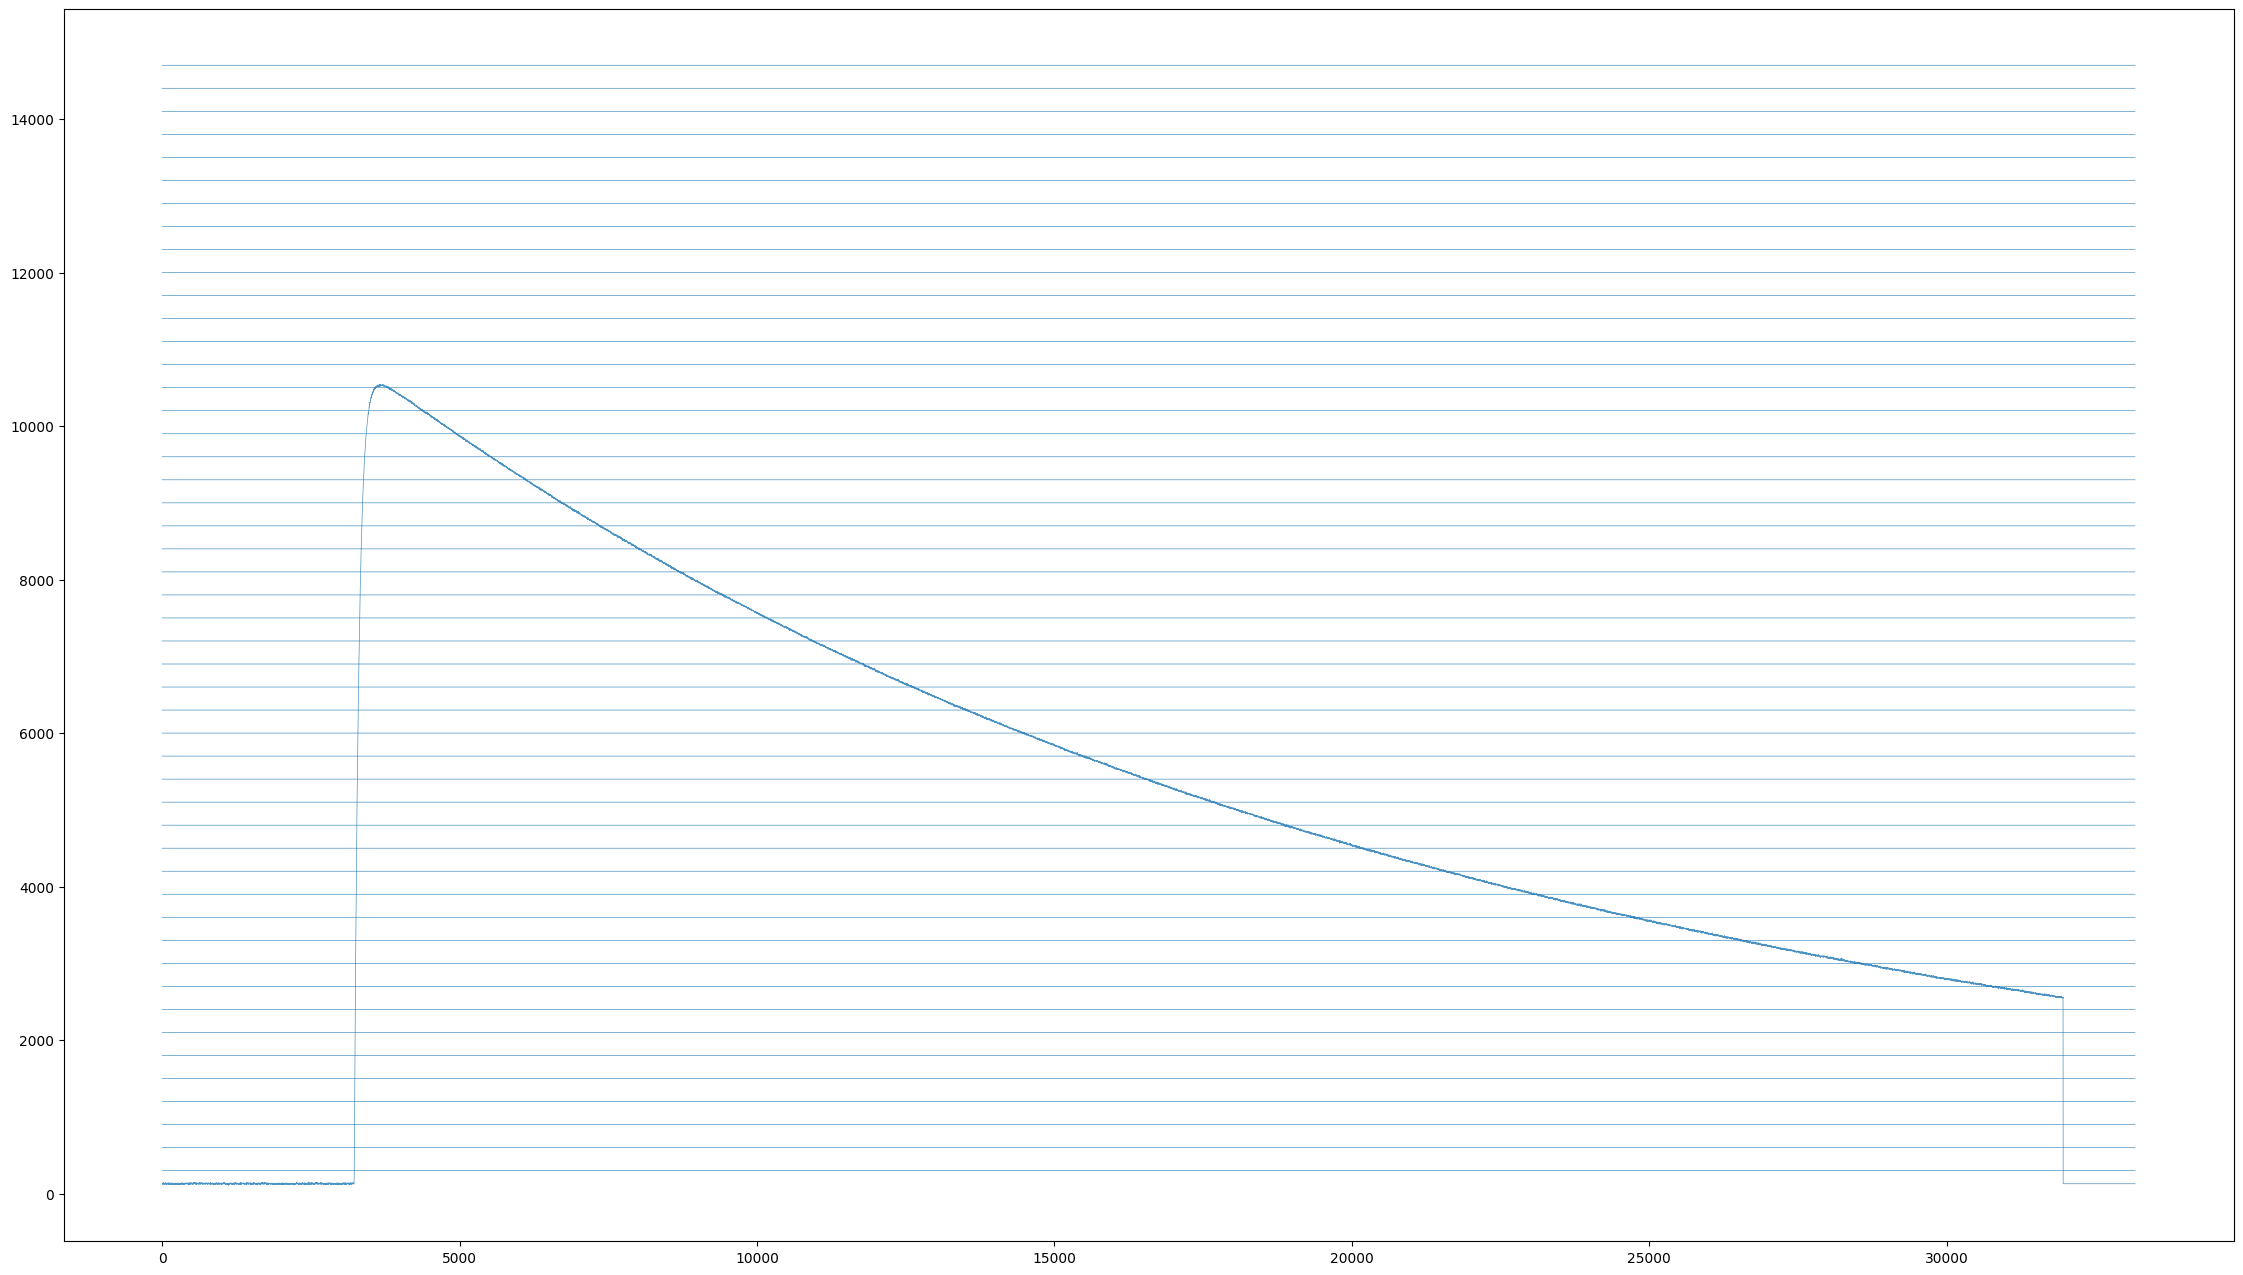

In [5]:
channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)

#template_path = './plugins/event_rqs/level2_template.npy'
#template_path = './plugins/event_rqs/template_K_alpha_tight.npy'
template_path = './plugins/event_rqs/default_templates.npy'

template = np.load(template_path, allow_pickle=True)


# change this to choose another event if the one below is a bad one by chance
i = 8

plt.figure(figsize=(28,16))
artificial_baselines = np.arange(len(channels)) * 300  # adding artificial baselines to each channel to separate the channels on the plot
plt.plot(events['channel_data'][i].T + artificial_baselines, lw=0.5, alpha=0.8, color='C0')  # plotting data in each channel

event = fit_results[i]

# plotting two-template fits in the vacuum channels
for i_vac, i_ch in enumerate(channels.indices_of_type(hx.ChannelType.SUBMERGED)):
    if i_vac != 0:
        continue 
    fit = event['submerged_channel_uv_amplitude'][i_vac] * np.roll(template, 0)
    x = np.arange(len(template))
    plt.plot(x, fit+artificial_baselines[i_ch], lw=1, alpha=0.8, color='C1')



plt.xlabel('Time (samples)')
plt.ylabel('Current (ADC units)')
plt.title(f'Apply MMC readout on silent traces')
plt.savefig('raw_traces_on_silent_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [45]:
def view_raw_records(context, run):
    records = context.get_array(run, 'raw_records')

    channels = hx.Channels(hx.DEFAULT_CHANNEL_MAP)

    for i in np.sort(np.unique(records['block_id'])):
        record_mask = records['block_id'] == i
        plt.figure(figsize=(12, 10))
        for ch in channels:
            mask = record_mask & (records['channel'] == ch)
            record = records['data'][mask][0]
            add_baseline = 300 * ch
            plt.plot(record + add_baseline, color='C0', lw=0.5)

        plt.xlabel('Time (samples)')
        plt.ylabel('Current w/artificial baselines (ADC)')
        plt.show()

        i += 1
        if i > 3:
            break



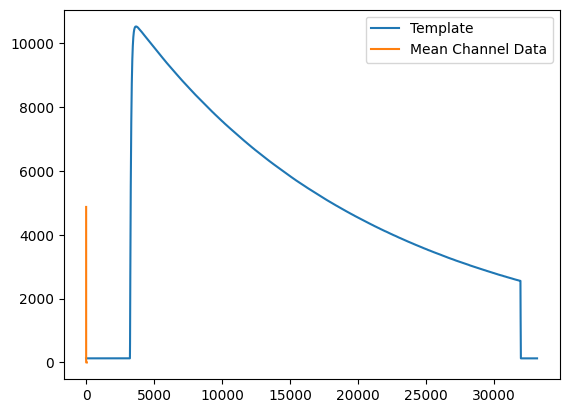

In [23]:
plt.plot(template, label="Template")
plt.plot(events['channel_data'][i].T.mean(axis=0), label="Mean Channel Data")
plt.legend()
plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def chi_square_fit_and_plot(data, template):
    """
    Performs Chi-Square (χ²) fitting using the given template and data.
    
    Parameters:
        data (numpy array): The 1D array representing the signal to be fitted.
        template (numpy array): The 1D template used for fitting.

    Returns:
        best_fit_amplitude (float): The optimal amplitude that best fits the data.
    """
    
    # Ensure float64 to prevent numerical issues
    data = data.astype(np.float64)
    template = template.astype(np.float64)

    # Normalize the template for stability
    template -= np.mean(template[:2048])  # Baseline correction
    template /= np.max(np.abs(template))  # Normalize peak to 1

    data -= np.mean(data[:2048])  # Align baseline of data

    # Define chi-square function
    def chi_square(A):
        model = A * template
        chi2 = np.sum(((data - model) ** 2) / (1e-3 + np.abs(data)))  # Avoid division by zero
        return chi2

    # Optimize amplitude A
    result = minimize(chi_square, x0=[np.max(data)], method='Nelder-Mead')
    best_fit_amplitude = result.x[0]

    # Compute fitted curve
    best_fit = best_fit_amplitude * template

    # Visualization
    plt.figure(figsize=(12, 6))

    # Plot raw data and fit
    plt.subplot(2, 1, 1)
    plt.plot(data, label='Raw Data', color='C0', alpha=0.7)
    plt.plot(best_fit, label='Best Fit', color='C1', linestyle='dashed', alpha=0.8)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.title("Chi-Square Fit")
    plt.legend()

    # Plot residuals
    plt.subplot(2, 1, 2)
    plt.plot(data - best_fit, color='C2', alpha=0.8)
    plt.axhline(0, color='gray', linestyle='dashed')
    plt.xlabel("Time (samples)")
    plt.ylabel("Residuals")
    plt.title("Fit Residuals")

    plt.tight_layout()
    plt.show()

    return best_fit_amplitude


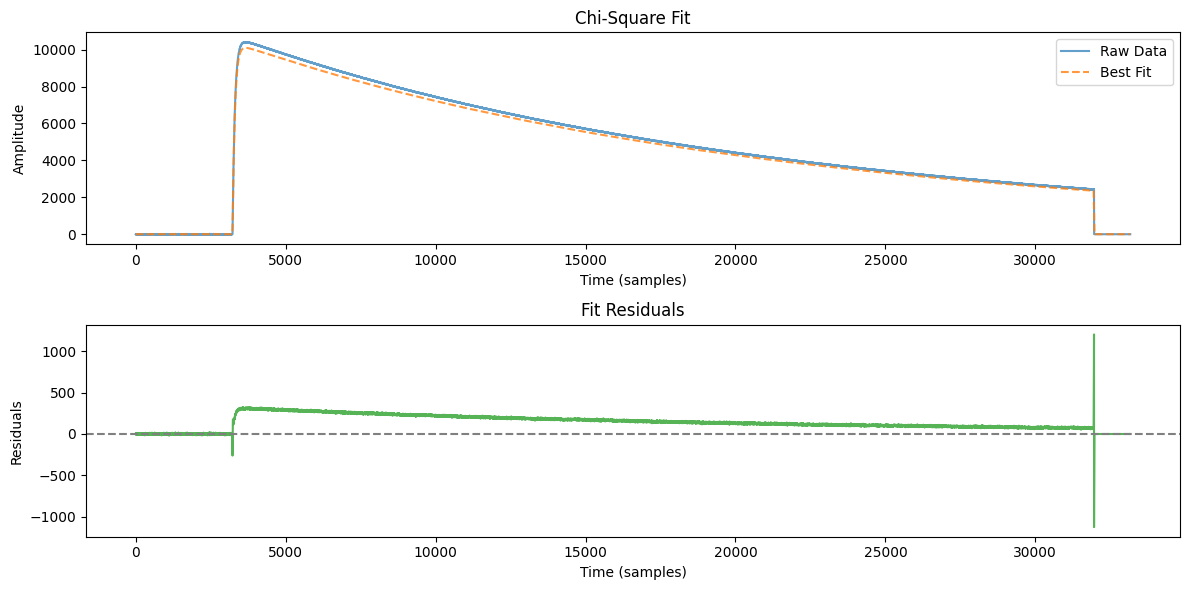

Best fit amplitude: 10093.420295797814


In [34]:
# Load your data and template
data = events['channel_data'][8][0]
template = np.load("./plugins/event_rqs/level2_template.npy")  # 1D template array

# Perform fitting
optimal_amplitude = chi_square_fit_and_plot(data, template)

print(f"Best fit amplitude: {optimal_amplitude}")
